In [ ]:
!pip install -U kaleido plotly -r https://raw.githubusercontent.com/crate/academy-fundamentals-course/main/notebooks/timeseries/requirements.txt

In [3]:
# import os
# import sqlalchemy as sa

# # Define database address when using CrateDB Cloud.
# # Please find these settings on your cluster overview page.
CONNECTION_STRING = os.environ.get(
    "CRATEDB_CONNECTION_STRING",
    "crate://<USERNAME>:<PASSWORD>@<HOST>/?ssl=true",
)

# # Define database address when using CrateDB on localhost.
# CONNECTION_STRING = os.environ.get(
#    "CRATEDB_CONNECTION_STRING",
#    "crate://crate@localhost/",
# )

# # Connect to CrateDB using SQLAlchemy.
# engine = sa.create_engine(CONNECTION_STRING, echo=os.environ.get('DEBUG'))
# connection = engine.connect()

In [4]:
_ = connection.execute(sa.text(
    """
    CREATE TABLE IF NOT EXISTS weather_data (
        "measurementid" TEXT,
        "station" TEXT,
        "ts" TIMESTAMP WITH TIME ZONE,
        "airtemp" DOUBLE PRECISION,
        "wetbulbtemp" DOUBLE PRECISION,
        "humidity" SMALLINT,
        "rainintensity" DOUBLE PRECISION,
        "intervalrain" DOUBLE PRECISION,
        "totalrain" DOUBLE PRECISION,
        "precipitationtype" SMALLINT,
        "winddirection" SMALLINT,
        "windspeed" DOUBLE PRECISION,
        "maxwindspeed" DOUBLE PRECISION,
        "pressure" DOUBLE PRECISION,
        "solarradiation" SMALLINT,
        "batterylife" DOUBLE PRECISION
    )
    """))

In [ ]:
result = connection.execute(sa.text("""
    COPY weather_data
    FROM 'https://github.com/crate/cratedb-datasets/raw/main/academy/chicago-data/beach_weather_station_data.csv'
    WITH (format='csv', empty_string_as_null=true) RETURN SUMMARY
    """))

info = result.mappings().first()
print(f"Records loaded: {info['success_count']}")
print(f"Errors: {info['error_count']}")
if info['error_count'] > 0:
    print(f"Errors: {info['errors']}")

In [6]:
_ = connection.execute(sa.text("REFRESH TABLE weather_data"))
_ = connection.execute(sa.text("ANALYZE"))

In [7]:
import pandas as pd
import numpy as np

query = """
SELECT ts, station, airtemp, humidity, intervalrain as rain FROM weather_data 
WHERE station in ('Foster', 'Oak Street') ORDER BY ts DESC LIMIT 10
"""
df = pd.read_sql(query, CONNECTION_STRING)
df['ts'] = np.array(pd.to_datetime(df['ts'], unit='ms'))
df

,ts,station,airtemp,humidity,rain
0,2024-07-10 09:00:00,Foster,19.28,85,0.20
1,2024-07-10 09:00:00,Oak Street,19.90,88,0.10
2,2024-07-10 08:00:00,Oak Street,20.90,90,0.40
3,2024-07-10 08:00:00,Foster,19.78,87,0.43
4,2024-07-10 07:00:00,Oak Street,21.00,85,1.90
5,2024-07-10 07:00:00,Foster,20.06,85,2.74
6,2024-07-10 06:00:00,Foster,20.56,88,4.42
7,2024-07-10 06:00:00,Oak Street,21.20,91,4.60
8,2024-07-10 05:00:00,Foster,20.56,87,2.29
9,2024-07-10 05:00:00,Oak Street,21.60,92,1.70


In [8]:
query = """
    SELECT
        station,
        AVG(airtemp) AS avg_temp
    FROM weather_data
    WHERE station IN ('Foster', 'Oak Street')
    GROUP BY station
    ORDER BY station
    """

df = pd.read_sql(query, CONNECTION_STRING)
df

,station,avg_temp
0,Foster,11.259153
1,Oak Street,13.309376


In [9]:
query = """
SELECT station,
    MAX(airtemp) AS max_temp,
    MAX_BY(ts, airtemp) AS time_of_max_temp,
    MIN(airtemp) AS min_temp,
    MIN_BY(ts, airtemp) AS time_of_min_temp
FROM weather_data
WHERE station in ('Foster', 'Oak Street')
GROUP BY station
ORDER BY station
"""

df_temperature = pd.read_sql(query, CONNECTION_STRING)

# milliseconds to datetime for better readability
df_temperature['time_of_max_temp'] = np.array(pd.to_datetime(df_temperature['time_of_max_temp'], unit='ms'))
df_temperature['time_of_min_temp'] = np.array(pd.to_datetime(df_temperature['time_of_min_temp'], unit='ms'))

df_temperature

,station,max_temp,time_of_max_temp,min_temp,time_of_min_temp
0,Foster,37.28,2023-08-24 22:00:00,-29.78,2019-01-30 14:00:00
1,Oak Street,37.60,2023-08-24 21:00:00,-21.40,2024-01-14 14:00:00


In [10]:
import datetime as dt
import plotly.express as px
import warnings

# Suppress a few warnings of pandas that will otherwise clutter the output.
warnings.simplefilter("ignore", category=FutureWarning)

In [11]:
# Take a quick glimpse at the data in tabular form.
# Select data from July 2023 onwards.
query = """
SELECT ts, station, airtemp, humidity, intervalrain as rain
FROM weather_data 
WHERE STATION IN ('Foster', 'Oak Street') AND ts >= 1688943600000 
ORDER BY station, ts
"""
df_weather = pd.read_sql(query, CONNECTION_STRING)
df_weather.head(10)

,ts,station,airtemp,humidity,rain
0,1688943600000,Foster,23.50,61,0.0
1,1688950800000,Foster,22.67,64,0.0
2,1688954400000,Foster,22.17,65,0.0
3,1688958000000,Foster,21.67,63,0.0
4,1688961600000,Foster,22.28,54,0.0
5,1688968800000,Foster,22.39,52,0.0
6,1688972400000,Foster,22.00,52,0.0
7,1688976000000,Foster,21.06,55,0.0
8,1688979600000,Foster,20.56,57,0.0
9,1688983200000,Foster,20.50,57,0.0


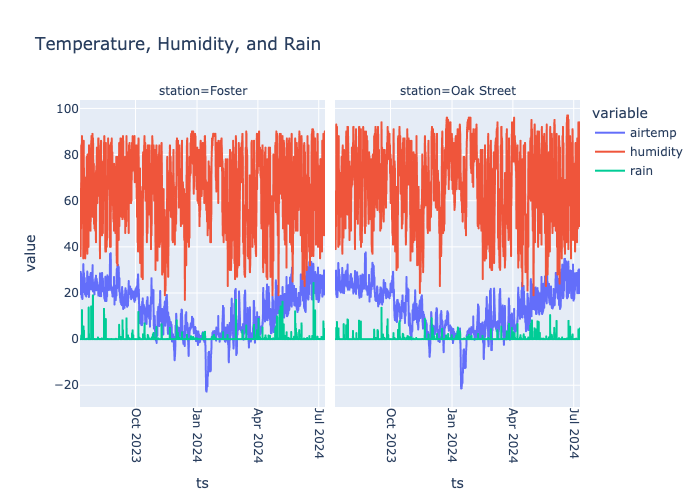

In [12]:
# Plot a line chart for temperature, humidity, and rain
# along the time axis, faceted by location.
df_weather['ts'] = pd.to_datetime(df_weather['ts'], unit='ms')
fig = px.line(
    df_weather, 
    x='ts', 
    y=['airtemp', 'humidity', 'rain'], 
    facet_col='station', 
    title='Temperature, Humidity, and Rain')
fig.update_xaxes(tickangle=90)

# We render as PNG here to show the results in the notebook
fig.show('png')

# Use fig.show() for interactive mode
#fig.show()

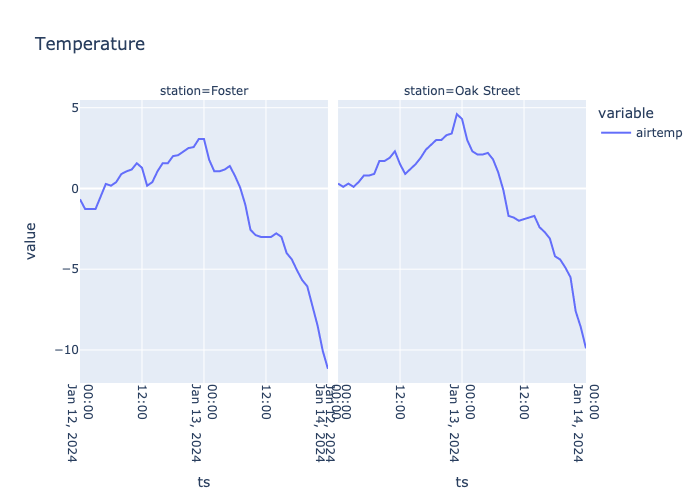

In [13]:
# Plot two days worth of temperature data.
fig = px.line(
    df_weather[df_weather['ts'].between(dt.datetime(2024, 1, 12), dt.datetime(2024, 1, 14))],
    x='ts', 
    y=['airtemp'], 
    facet_col='station', 
    title='Temperature')
fig.update_xaxes(tickangle=90)

# We render as PNG here to show the results in the notebook
fig.show('png')

# Use fig.show() for interactive mode
#fig.show()

In [14]:
# Now let's make some holes in the data and refresh our query...
_ = connection.execute(sa.text("""
    UPDATE weather_data SET airtemp = NULL WHERE measurementid IN
    ('Foster202401121100', 'Foster202401121300', 'Foster202401121600', 
     'Foster202401132400', 'Foster202401130300', 'Foster202401130600',
     'OakStreet202401120400', 'OakStreet202401120800', 'OakStreet202401121000',
     'OakStreet202401121300', 'OakStreet202401121600', 'OakStreet202401121700',
     'OakStreet202401130400', 'OakStreet202401130700', 'OakStreet202401130900',
     'OakStreet202401131300', 'OakStreet202401131400', 'OakStreet202401131700')
    """))

_ = connection.execute(sa.text("REFRESH TABLE weather_data"))

# Re-run a query to refresh our data.
query = """
SELECT ts, station, airtemp, humidity, intervalrain as rain
FROM weather_data 
WHERE STATION IN ('Foster', 'Oak Street') AND ts >= 1688943600000 
ORDER BY station, ts
"""
df_weather = pd.read_sql(query, CONNECTION_STRING)

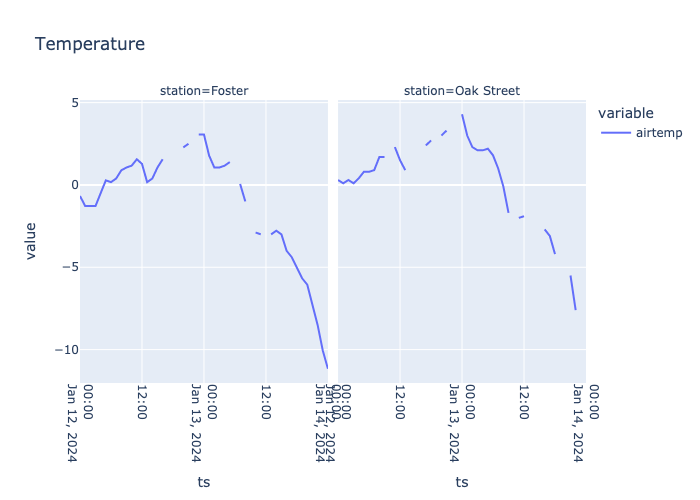

In [15]:
# Plot two days worth of temperature data.
df_weather['ts'] = pd.to_datetime(df_weather['ts'], unit='ms')
fig = px.line(
    df_weather[df_weather['ts'].between(dt.datetime(2024, 1, 12), dt.datetime(2024, 1, 14))],
    x='ts', 
    y=['airtemp'], 
    facet_col='station', 
    title='Temperature')
fig.update_xaxes(tickangle=90)

# We render as PNG here to show the results in the notebook
fig.show('png')

# Use fig.show() for interactive mode
#fig.show()

In [16]:
# Now fix the holes with interpolation.
query = """
WITH OrderedData AS (
    SELECT ts,
           station,
           airtemp,
           COALESCE(LAG(airtemp, 1) IGNORE NULLS OVER station_window, airtemp) AS prev_airtemp,
           COALESCE(LEAD(airtemp, 1) IGNORE NULLS OVER station_window, airtemp) AS next_airtemp
    FROM weather_data
    WINDOW station_window AS (partition by station ORDER BY station, ts)
)
SELECT ts,
       station,
       airtemp,
       COALESCE(airtemp, (prev_airtemp + next_airtemp) / 2) as airtemp_interpolated
FROM OrderedData
WHERE station IN ('Foster', 'Oak Street')
AND ts >= 1705017600000 AND ts <= 1705190400000
ORDER BY station, ts
"""

df_weather = pd.read_sql(query, CONNECTION_STRING)
df_weather['ts'] = pd.to_datetime(df_weather['ts'], unit='ms')
df_weather.head(24)

,ts,station,airtemp,airtemp_interpolated
0,2024-01-12 00:00:00,Foster,-0.67,-0.67
1,2024-01-12 01:00:00,Foster,-1.28,-1.28
2,2024-01-12 02:00:00,Foster,-1.28,-1.28
3,2024-01-12 03:00:00,Foster,-1.28,-1.28
4,2024-01-12 05:00:00,Foster,0.28,0.28
5,2024-01-12 06:00:00,Foster,0.17,0.17
6,2024-01-12 07:00:00,Foster,0.39,0.39
7,2024-01-12 08:00:00,Foster,0.89,0.89
8,2024-01-12 09:00:00,Foster,1.06,1.06
9,2024-01-12 10:00:00,Foster,1.17,1.17


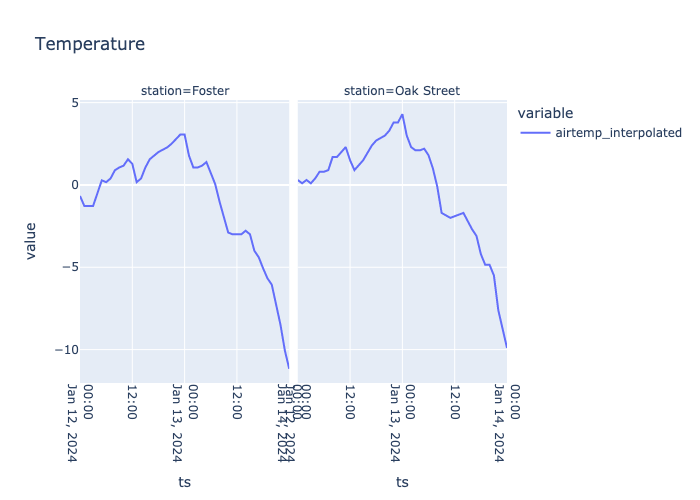

In [17]:
# And re plot the data.
df_weather['ts'] = pd.to_datetime(df_weather['ts'], unit='ms')
fig = px.line(
    df_weather[df_weather['ts'].between(dt.datetime(2024, 1, 12), dt.datetime(2024, 1, 14))],
    x='ts', 
    y=['airtemp_interpolated'], 
    facet_col='station', 
    title='Temperature')
fig.update_xaxes(tickangle=90)

# We render as PNG here to show the results in the notebook
fig.show('png')

# Use fig.show() for interactive mode
#fig.show()

In [18]:
# Now create a general purpose view.
query = """
CREATE OR REPLACE VIEW weather_data_interpolated AS (
    WITH OrderedData AS (
        SELECT ts,
               station,
               airtemp,
               COALESCE(LAG(airtemp, 1) IGNORE NULLS OVER station_window, airtemp) AS prev_airtemp,
               COALESCE(LEAD(airtemp, 1) IGNORE NULLS OVER station_window, airtemp) AS next_airtemp,
               humidity,
               COALESCE(LAG(humidity, 1) IGNORE NULLS OVER station_window, humidity) AS prev_humidity,
               COALESCE(LEAD(humidity, 1) IGNORE NULLS OVER station_window, humidity) AS next_humidity,
               intervalrain as rain,
               COALESCE(LAG(intervalrain, 1) IGNORE NULLS OVER station_window, intervalrain) AS prev_rain,
               COALESCE(LEAD(intervalrain, 1) IGNORE NULLS OVER station_window, intervalrain) AS next_rain
        FROM weather_data
        WINDOW station_window AS (partition by station ORDER BY station, ts)
    )
    SELECT ts,
           station,
           COALESCE(airtemp, (prev_airtemp + next_airtemp) / 2) as airtemp,
           COALESCE(humidity, (prev_humidity + next_humidity) / 2) as humidity,
           COALESCE(rain, (prev_rain + next_rain) / 2) as rain
    FROM OrderedData
    ORDER BY station, ts
)
"""

_ = connection.execute(sa.text(query))

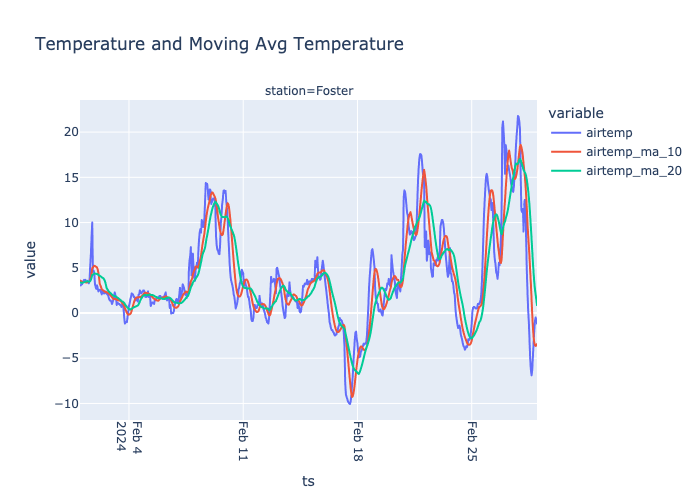

In [19]:
# Now use the view for moving averages.
query = """
SELECT 
    ts, 
    station,
    airtemp,
    AVG(airtemp) OVER w_10 AS airtemp_ma_10,
    AVG(airtemp) OVER w_20 AS airtemp_ma_20,
    humidity,
    AVG(humidity) OVER w_10 AS humidity_ma_10,
    AVG(humidity) OVER w_20 AS humidity_ma_20,
    rain,
    AVG(rain) OVER w_10 AS rain_ma_10,
    AVG(rain) OVER w_20 AS rain_ma_20
FROM 
    weather_data_interpolated
WHERE station = 'Foster' AND ts >= 1688943600000 
WINDOW
    w_10 AS (ORDER BY station, ts ROWS BETWEEN 10 PRECEDING AND CURRENT ROW),
    w_20 AS (ORDER BY station, ts ROWS BETWEEN 20 PRECEDING AND CURRENT ROW)
"""

df_weather_ma = pd.read_sql(query, CONNECTION_STRING)
df_weather_ma['ts'] = pd.to_datetime(df_weather_ma['ts'], unit='ms')

# Plot data including moving averages.
fig = px.line(
    df_weather_ma[df_weather_ma['ts'].between(dt.datetime(2024, 2, 1), dt.datetime(2024, 2, 29))],
    x='ts', 
    y=['airtemp', 'airtemp_ma_10', 'airtemp_ma_20'], 
    facet_col='station', 
    title='Temperature and Moving Avg Temperature')
fig.update_xaxes(tickangle=90)

# We render as PNG here to show the results in the notebook
fig.show('png')

# Use fig.show() for interactive mode
#fig.show()

In [20]:
# Add a new column to the table to store dynamic document / object data.
_ = connection.execute(sa.text('ALTER TABLE weather_data ADD COLUMN attributes OBJECT(DYNAMIC)'))

# Update some of the records with metadata.
_ = connection.execute(sa.text("""
UPDATE weather_data SET attributes = '
{
    "sensorinfo": {
        "hardware": {
            "serialnumber": "AB12ZZZZ3",
            "version": "1.2",
            "sensortype": "AM2320"
        },
        "lastcalibrationdate": "2022-11-10"
    }
}
' WHERE station = 'Foster' AND ts >= 1672556400000 AND ts <= 1680505200000
"""))

_ = connection.execute(sa.text("""
UPDATE weather_data SET attributes = '
{
    "sensorinfo": {
        "hardware": {
            "serialnumber": "SH045742A",
            "version": "1.2",
            "sensortype": "SHT45"
        },
        "lastcalibrationdate": "2022-12-15"
    }
}
' WHERE station = 'Oak Street' AND ts >= 1672556400000 AND ts <= 1685862000000
"""))

_ = connection.execute(sa.text("""
UPDATE weather_data SET attributes = '
{
    "sensorinfo": {
        "hardware": {
            "serialnumber": "AB12ZZZZ3",
            "version": "1.3",
            "sensortype": "AM2320"
        },
        "lastcalibrationdate": "2023-04-01"
    }
}
' WHERE station = 'Foster' AND ts >= 1680505200000
"""))

_ = connection.execute(sa.text("""
UPDATE weather_data SET attributes = '
{
    "sensorinfo": {
        "hardware": {
            "serialnumber": "SH045742A",
            "version": "1.3",
            "sensortype": "SHT45"
        },
        "lastcalibrationdate": "2023-03-22"
    }
}
' WHERE station = 'Oak Street' AND ts >= 1680505200000 AND ts <= 1690786800000
"""))

_ = connection.execute(sa.text("""
UPDATE weather_data SET attributes = '
{
    "sensorinfo": {
        "hardware": {
            "serialnumber": "SH045742A",
            "version": "1.4",
            "sensortype": "SHT45"
        },
        "lastcalibrationdate": "2023-06-18"
    }
}
' WHERE station = 'Oak Street' AND ts >= 1690786800000
"""))

# Refresh the table before querying.

_ = connection.execute(sa.text("REFRESH TABLE weather_data"))
_ = connection.execute(sa.text("ANALYZE"))

In [21]:
# Querying all of the metadata...
query = """
SELECT station, attributes FROM weather_data WHERE ts > 1712012400000 AND ts < 1712023200000
"""

df_all_attrs = pd.read_sql(query, CONNECTION_STRING)
df_all_attrs

,station,attributes
0,Foster,{'sensorinfo': {'lastcalibrationdate': '2023-0...
1,Foster,{'sensorinfo': {'lastcalibrationdate': '2023-0...
2,Oak Street,{'sensorinfo': {'lastcalibrationdate': '2023-0...
3,Oak Street,{'sensorinfo': {'lastcalibrationdate': '2023-0...


In [22]:
df_all_attrs = df_all_attrs.join(pd.json_normalize(df_all_attrs.pop('attributes')))
df_all_attrs

,station,sensorinfo.lastcalibrationdate,sensorinfo.hardware.serialnumber,sensorinfo.hardware.sensortype,sensorinfo.hardware.version
0,Foster,2023-04-01,AB12ZZZZ3,AM2320,1.3
1,Foster,2023-04-01,AB12ZZZZ3,AM2320,1.3
2,Oak Street,2023-06-18,SH045742A,SHT45,1.4
3,Oak Street,2023-06-18,SH045742A,SHT45,1.4


In [23]:
# Querying the metadata -- markdown example query then json normalize example in here
query = """
SELECT 
    station, 
    attributes['sensorinfo']['hardware']['version'] AS version, 
    count(*) AS readings 
FROM weather_data 
WHERE station IN ('Foster', 'Oak Street') 
GROUP BY station, version 
ORDER BY station, version
"""

df_sensor_version_info = pd.read_sql(query, CONNECTION_STRING)
df_sensor_version_info

,station,version,readings
0,Foster,1.2,2151
1,Foster,1.3,10642
2,Foster,None,51473
3,Oak Street,1.2,2154
4,Oak Street,1.3,2820
5,Oak Street,1.4,7973
6,Oak Street,None,46940


In [24]:
# Add meta data in a separate table.
query = """
CREATE TABLE IF NOT EXISTS weather_stations (
    stationid TEXT,
    location GEO_POINT,
    additionalinfo OBJECT(STRICT) AS (
        altitude SMALLINT,
        manager TEXT,
        established SMALLINT
    )
)
"""

_ = connection.execute(sa.text(query))

query = """
INSERT INTO weather_stations (stationid, location, additionalinfo) VALUES 
('Foster', 'POINT(-87.647525 41.976464)', '{"altitude": 179, "manager": "Chicago Park District", "established": 2003}'),
('Oak Street', 'POINT(-87.6228169 41.901997)', '{"altitude": 185, "manager": "Chicago Park District", "established": 2001}')
"""

_ = connection.execute(sa.text(query))

In [25]:
query = """
SELECT
    ts, station, airtemp, humidity, location, additionalinfo['altitude'] AS altitude
FROM
    weather_data 
LEFT JOIN weather_stations ON
    (weather_data.station = weather_stations.stationid)
ORDER BY ts DESC
LIMIT 5
"""

df_weather_stations = pd.read_sql(query, CONNECTION_STRING)
df_weather_stations['ts'] = pd.to_datetime(df_weather_stations['ts'], unit='ms')

df_weather_stations

,ts,station,airtemp,humidity,location,altitude
0,2024-07-10 09:00:00,Foster,19.28,85,"[-87.647525, 41.976464]",179
1,2024-07-10 09:00:00,Oak Street,19.90,88,"[-87.6228169, 41.901997]",185
2,2024-07-10 08:00:00,Foster,19.78,87,"[-87.647525, 41.976464]",179
3,2024-07-10 08:00:00,Oak Street,20.90,90,"[-87.6228169, 41.901997]",185
4,2024-07-10 07:00:00,Foster,20.06,85,"[-87.647525, 41.976464]",179
